# Pandas analysis

In the following a series of exercises is proposed on a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGA's. Each measurement (i.e. each row) consists of the address of the TDC providing the signal, 'FPGA' and 'TDC_Channel, and the timing information itself, 'ORBIT_CNT', 'BX_COUNTER' and 'TDC_MEAS'. Each TDC count correspond 25/30 ns, whereas the BX_COUNTER feauters gets updated every 25 ns and the ORBIT_CNT every 'x' BX_COUNTER. You can see these way of storing the time as similar to hours, minutes and seconds. Note that the first column/variable is named HEAD .

In [1]:
import pandas as pd
import numpy
import IPython
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1. Create a Pandas DataFrame by read N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

In [2]:
file_name="data\data_000637.txt"
data=pd.read_csv(file_name)
N=20000
df0 = pd.DataFrame(data.iloc[0:N,:])
print(IPython.display.display(df0))

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29
19996,1,0,63,3869200366,2517,6
19997,1,0,32,3869200366,2519,5
19998,1,0,17,3869200366,2522,21


None


2. Find out the value of 'x'

In [3]:
df = pd.DataFrame(data)
max_ = df['BX_COUNTER'].max()
min_ = df['BX_COUNTER'].min()
x = max_ - min_
print('x is:',x)

x is: 3563


3. Find out how much the data taking lasted. You can either make an estimate on the basis of the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset

In [4]:
max_ = df['ORBIT_CNT'].max()
min_ = df['ORBIT_CNT'].min()
x = max_ - min_
c = x*3563*25*(10**-9)
print('The data taking lasted for about:',c,'s')

The data taking lasted for about: 0.9801813 s


4. Create a new column with the actual time in ns (as a combination of the other three columns with timing information)

In [5]:
time0 = (df.iloc[0]['ORBIT_CNT']*(3563*25) + df.iloc[0]['BX_COUNTER']*25 + df.iloc[0]['TDC_MEAS']*(25/30))
df['time(ns)']= ((df['TDC_MEAS'] + df['BX_COUNTER']*30 + df['ORBIT_CNT']*3563*30) *25/30)-time0
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time(ns)
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,7.500000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649188e+03
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,9.801410e+08
1310716,1,1,4,3869211171,763,11,9.801410e+08
1310717,1,0,64,3869211171,764,0,9.801410e+08
1310718,1,0,139,3869211171,769,0,9.801412e+08


5. Replace the values (all 1) of the HEAD column randomly with 0 or 1

# Run this program as last, otherwise the following programs will take this Data Frame as the default one

In [10]:
df1 = pd.DataFrame(data)
df1['HEAD'] = pd.DataFrame(np.random.randint(0,2,len(df)))
IPython.display.display(df1)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time(ns)
0,1,0,123,3869200167,2374,26,0.000000e+00
1,0,0,124,3869200167,2374,27,7.500000e-01
2,0,0,63,3869200167,2553,28,4.476625e+03
3,0,0,64,3869200167,2558,19,4.594125e+03
4,0,0,64,3869200167,2760,25,9.649188e+03
...,...,...,...,...,...,...,...
1310715,0,0,62,3869211171,762,14,9.801410e+08
1310716,1,1,4,3869211171,763,11,9.801410e+08
1310717,1,0,64,3869211171,764,0,9.801410e+08
1310718,1,0,139,3869211171,769,0,9.801412e+08


6. Create a new DataFrame with only the rows with HEAD=1

In [6]:
df2 = pd.DataFrame(df[df['HEAD']==1])
IPython.display.display(df2)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time(ns)
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,7.500000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649188e+03
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,9.801410e+08
1310716,1,1,4,3869211171,763,11,9.801410e+08
1310717,1,0,64,3869211171,764,0,9.801410e+08
1310718,1,0,139,3869211171,769,0,9.801412e+08


7. Make two occupancy plots (one per FPGA), i.e. plot the number of counts per TDC channel

In [ ]:
#Grouped with two FPGA 0 or 1 and the counting the HEAD = 1 for every channel

HEAD
TDC_CHANNEL FPGA       
1           0      1215
            1     28438
2           0      1602
            1     32669
3           0      1493
...                 ...
137         1        36
138         0        34
            1        36
139         0     75617
            1     32442

[256 rows x 1 columns]

FPGA
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

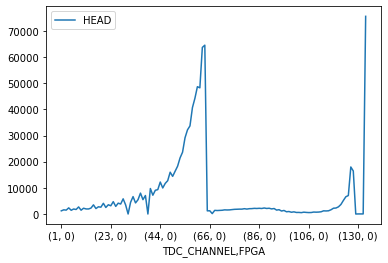

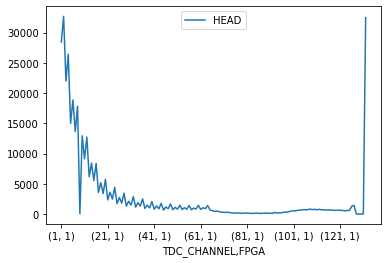

In [7]:
df3 = df.groupby(['TDC_CHANNEL','FPGA'])[['HEAD']].sum()
IPython.display.display(df3)
df3.groupby(['FPGA']).plot()

8. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [8]:
df4 = df.groupby(['TDC_CHANNEL'])[['HEAD']].sum()
df4.nlargest(3, 'HEAD')

,HEAD
TDC_CHANNEL,
139,108059
64,66020
63,64642


9. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [9]:
print("The number of unique orbits is:",len(df['ORBIT_CNT'].value_counts()))

df5 = pd.DataFrame(df[df['TDC_CHANNEL']==139])
print("The number of unique orbits with at least one measurement from TDC_CHANNEL = 139 is:",len(df5['ORBIT_CNT'].value_counts()))
IPython.display.display(df5)

The number of unique orbits is: 11001
The number of unique orbits with at least one measurement from TDC_CHANNEL = 139 is: 10976


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time(ns)
7,1,0,139,3869200167,2776,0,1.002831e+04
15,1,1,139,3869200167,2797,0,1.055331e+04
30,1,0,139,3869200167,3085,0,1.775331e+04
39,1,0,139,3869200167,3186,0,2.027831e+04
48,1,0,139,3869200168,23,0,3.027831e+04
...,...,...,...,...,...,...,...
1310650,1,1,139,3869211170,2959,0,9.801068e+08
1310660,1,0,139,3869211170,3027,0,9.801085e+08
1310685,1,0,139,3869211170,3230,0,9.801136e+08
1310701,1,0,139,3869211171,21,0,9.801225e+08
